# Optimizing a Trading Strategy Using Optuna: A Case Study on AAPL
- Axel Santiago Molina Ceja 
- Pablo Lemus Castellanos

## Introduction

In this project, we developed and optimized a quantitative trading strategy using Optuna, a powerful hyperparameter optimization framework. The strategy was tested on historical 5-minute interval data for Apple Inc. (AAPL), and a backtesting system was implemented to evaluate its performance.

We optimized not only the entry and exit rules using technical indicators (RSI, Bollinger Bands, MACD), but also the position sizing (number of shares). Our objective was to maximize the risk-adjusted performance of the strategy.


## Load Data and Required Libraries
We begin by importing the necessary libraries and loading the historical AAPL dataset (5-minute intervals).

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import optuna
import ta

data = pd.read_csv("aapl_5m_train.csv").dropna()

## Objective Function for Optuna Optimization

This function defines the strategy logic and calculates the Sharpe Ratio based on suggested parameters.

It:
- Suggests hyperparameters for indicators and trade management.
- Calculates RSI, Bollinger Bands, and MACD.
- Executes trades based on combined signals.
- Tracks portfolio value and computes performance metrics.


In [2]:
def objective(trial, data):
    data = data.copy()
    
    # Hiperparámetros
    rsi_window = trial.suggest_int("rsi_window", 10, 100)
    rsi_upper = trial.suggest_int("rsi_upper", 70, 95)
    rsi_lower = trial.suggest_int("rsi_lower", 5, 30)
    
    stop_loss = trial.suggest_float("stop_loss", 0.04, 0.12)
    take_profit = trial.suggest_float("take_profit", 0.04, 0.12)
    
    bb_window = trial.suggest_int("bb_window", 10, 100)
    bb_std = trial.suggest_int("bb_std", 1, 3)
    
    macd_short = trial.suggest_int("macd_short", 10, 50)
    macd_long = trial.suggest_int("macd_long", 50, 200)
    macd_signal = trial.suggest_int("macd_signal", 5, 20)

    n_shares = trial.suggest_int("n_shares", 2000, 5000, step=1000)

    # Indicadores técnicos
    data["RSI"] = ta.momentum.RSIIndicator(data.Close, window=rsi_window).rsi()
    bb = ta.volatility.BollingerBands(data.Close, window=bb_window, window_dev=bb_std)
    data["BB"] = bb.bollinger_mavg()
    data["BB_BUY"] = bb.bollinger_lband_indicator().astype(bool)
    data["BB_SELL"] = bb.bollinger_hband_indicator().astype(bool)
    macd = ta.trend.MACD(data.Close, window_slow=macd_long, window_fast=macd_short, window_sign=macd_signal)
    data["MACD"] = macd.macd()
    data["MACD_SIGNAL"] = macd.macd_signal()
    
    dataset = data.dropna()
    
    # Simulación de estrategia
    capital = 1_000_000
    com = 0.125 / 100
    portfolio_value = [capital]
    active_long = None
    active_short = None
    win = 0
    loss = 0
    
    for i, row in dataset.iterrows():
        # Cierre de posiciones largas
        if active_long:
            if row.Close >= active_long["take_profit"] or row.Close <= active_long["stop_loss"]:
                pnl = row.Close * active_long["n_shares"] * (1 - com)
                capital += pnl
                win += 1 if row.Close >= active_long["take_profit"] else 0
                loss += 1 if row.Close <= active_long["stop_loss"] else 0
                active_long = None
        
        # Cierre de posiciones cortas
        if active_short:
            if row.Close <= active_short["take_profit"] or row.Close >= active_short["stop_loss"]:
                pnl = (active_short["opened_at"] - row.Close) * active_short["n_shares"] * (1 - com)
                capital += pnl
                win += 1 if row.Close <= active_short["take_profit"] else 0
                loss += 1 if row.Close >= active_short["stop_loss"] else 0
                active_short = None
        
        # Entrada larga
        if sum([row.RSI < rsi_lower, row.BB_BUY, row.MACD > row.MACD_SIGNAL]) >= 2 and not active_long:
            cost = row.Close * n_shares * (1 + com)
            if capital >= cost:
                capital -= cost
                active_long = {
                    "opened_at": row.Close, 
                    "take_profit": row.Close * (1 + take_profit), 
                    "stop_loss": row.Close * (1 - stop_loss), 
                    "n_shares": n_shares
                }
        
        # Entrada corta
        if sum([row.RSI > rsi_upper, row.BB_SELL, row.MACD < row.MACD_SIGNAL]) >= 2 and not active_short:
            cost = row.Close * n_shares * com
            if capital >= cost:
                capital -= cost
                active_short = {
                    "opened_at": row.Close, 
                    "take_profit": row.Close * (1 - take_profit), 
                    "stop_loss": row.Close * (1 + stop_loss), 
                    "n_shares": n_shares
                }
        
        # Valor del portafolio
        long_val = active_long["opened_at"] * active_long["n_shares"] if active_long else 0
        short_val = (active_short["opened_at"] - row.Close) * active_short["n_shares"] if active_short else 0
        portfolio_value.append(capital + long_val + short_val)
    
    # Métricas
    rets = pd.Series(portfolio_value).pct_change().dropna()
    er = rets.mean()
    ev = rets.std()
    dt = (252)*(6.5)*(60/5)
    sharpe_ratio = (er * dt) / (ev * np.sqrt(dt))
    returns = np.diff(portfolio_value) / portfolio_value[:-1]
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns)
    sortino_ratio = (np.mean(returns) * dt) / (downside_std * np.sqrt(dt)) if downside_std != 0 else 0
    calmar_ratio = (np.mean(returns) * dt) / abs(min(returns)) if min(returns) != 0 else 0
    win_loss_ratio = win / (win + loss) if (win + loss) != 0 else 0
    
    return sharpe_ratio if not np.isnan(sharpe_ratio) else -np.inf

## Run Optimization with 50 Trials

We now run the Optuna study to search for the best hyperparameter configuration based on the Sharpe Ratio.

In [3]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda x: objective(x, data), n_trials=50)

[I 2025-03-27 19:34:50,115] A new study created in memory with name: no-name-94a1476c-e1cc-4cd1-a9a4-275d689103fa
[I 2025-03-27 19:34:59,897] Trial 0 finished with value: -0.4063829232649988 and parameters: {'rsi_window': 48, 'rsi_upper': 77, 'rsi_lower': 16, 'stop_loss': 0.05821951709799261, 'take_profit': 0.06138930940084114, 'bb_window': 22, 'bb_std': 3, 'macd_short': 26, 'macd_long': 83, 'macd_signal': 10, 'n_shares': 3000}. Best is trial 0 with value: -0.4063829232649988.
[I 2025-03-27 19:35:10,605] Trial 1 finished with value: 0.19503283975695768 and parameters: {'rsi_window': 97, 'rsi_upper': 91, 'rsi_lower': 28, 'stop_loss': 0.11931688387719996, 'take_profit': 0.08089991091457885, 'bb_window': 61, 'bb_std': 1, 'macd_short': 47, 'macd_long': 198, 'macd_signal': 9, 'n_shares': 2000}. Best is trial 1 with value: 0.19503283975695768.
[I 2025-03-27 19:35:19,911] Trial 2 finished with value: 0.7116257956930393 and parameters: {'rsi_window': 61, 'rsi_upper': 92, 'rsi_lower': 8, 'stop_

[I 2025-03-27 19:38:15,740] Trial 20 finished with value: 1.2275674488587283 and parameters: {'rsi_window': 40, 'rsi_upper': 82, 'rsi_lower': 22, 'stop_loss': 0.047708513605641725, 'take_profit': 0.10348207285616026, 'bb_window': 83, 'bb_std': 2, 'macd_short': 30, 'macd_long': 94, 'macd_signal': 20, 'n_shares': 3000}. Best is trial 17 with value: 1.3378550163313605.
[I 2025-03-27 19:38:25,703] Trial 21 finished with value: 1.1235991230968732 and parameters: {'rsi_window': 39, 'rsi_upper': 82, 'rsi_lower': 22, 'stop_loss': 0.046902356941094604, 'take_profit': 0.10126593063111106, 'bb_window': 86, 'bb_std': 2, 'macd_short': 30, 'macd_long': 93, 'macd_signal': 20, 'n_shares': 3000}. Best is trial 17 with value: 1.3378550163313605.
[I 2025-03-27 19:38:35,543] Trial 22 finished with value: 0.825895974318279 and parameters: {'rsi_window': 34, 'rsi_upper': 82, 'rsi_lower': 24, 'stop_loss': 0.046611967957724064, 'take_profit': 0.08872457968812099, 'bb_window': 85, 'bb_std': 2, 'macd_short': 28

[I 2025-03-27 19:42:02,832] Trial 43 finished with value: 0.28222034981737115 and parameters: {'rsi_window': 22, 'rsi_upper': 79, 'rsi_lower': 21, 'stop_loss': 0.040370725096946454, 'take_profit': 0.09953486901815954, 'bb_window': 75, 'bb_std': 2, 'macd_short': 33, 'macd_long': 59, 'macd_signal': 18, 'n_shares': 3000}. Best is trial 41 with value: 1.4330554831623787.
[I 2025-03-27 19:42:12,803] Trial 44 finished with value: 0.9292391862216114 and parameters: {'rsi_window': 59, 'rsi_upper': 85, 'rsi_lower': 23, 'stop_loss': 0.06010670399467305, 'take_profit': 0.10466984310319018, 'bb_window': 85, 'bb_std': 2, 'macd_short': 40, 'macd_long': 99, 'macd_signal': 19, 'n_shares': 3000}. Best is trial 41 with value: 1.4330554831623787.
[I 2025-03-27 19:42:22,290] Trial 45 finished with value: 1.063731634133443 and parameters: {'rsi_window': 36, 'rsi_upper': 81, 'rsi_lower': 20, 'stop_loss': 0.04543047801667971, 'take_profit': 0.09690601480531127, 'bb_window': 98, 'bb_std': 2, 'macd_short': 32,

## Best Trial Results

Here are the best parameters found by Optuna, which achieved the highest Sharpe Ratio.


In [4]:
print("Best Sharpe Ratio:", study.best_value)
print("Best Parameters:", study.best_params)

Best Sharpe Ratio: 1.4330554831623787
Best Parameters: {'rsi_window': 37, 'rsi_upper': 83, 'rsi_lower': 22, 'stop_loss': 0.04765239471273998, 'take_profit': 0.10028371638672794, 'bb_window': 86, 'bb_std': 2, 'macd_short': 32, 'macd_long': 88, 'macd_signal': 18, 'n_shares': 3000}


## Backtesting with Optimal Parameters

We run the strategy again using the best parameters to evaluate final performance and visualize the portfolio curve.

In [5]:
def run_strategy(data, params):
    data = data.copy()
    
    rsi_window = params["rsi_window"]
    rsi_upper = params["rsi_upper"]
    rsi_lower = params["rsi_lower"]
    stop_loss = params["stop_loss"]
    take_profit = params["take_profit"]
    bb_window = params["bb_window"]
    bb_std = params["bb_std"]
    macd_short = params["macd_short"]
    macd_long = params["macd_long"]
    macd_signal = params["macd_signal"]
    n_shares = params["n_shares"]
    
    # Cálculo de indicadores
    rsi = ta.momentum.RSIIndicator(data.Close, window=rsi_window)
    data["RSI"] = rsi.rsi()
    bb = ta.volatility.BollingerBands(data.Close, window=bb_window, window_dev=bb_std)
    data["BB"] = bb.bollinger_mavg()
    data["BB_BUY"] = bb.bollinger_lband_indicator().astype(bool)
    data["BB_SELL"] = bb.bollinger_hband_indicator().astype(bool)
    macd = ta.trend.MACD(data.Close, window_slow=macd_long, window_fast=macd_short, window_sign=macd_signal)
    data["MACD"] = macd.macd()
    data["MACD_SIGNAL"] = macd.macd_signal()

    dataset = data.dropna()

    capital = 1_000_000
    com = 0.125/100
    portfolio_value = [capital]
    active_long = None
    active_short = None
    win = 0
    loss = 0

    for i, row in dataset.iterrows():
        # Close long positions
        if active_long:
            if row.Close >= active_long["take_profit"] or row.Close <= active_long["stop_loss"]:
                pnl = row.Close * n_shares * (1-com)
                capital += pnl
                win += 1 if row.Close >= active_long["take_profit"] else 0
                loss += 1 if row.Close <= active_long["stop_loss"] else 0
                active_long = None

        # Close short positions
        if active_short:
            if row.Close <= active_short["take_profit"] or row.Close >= active_short["stop_loss"]:
                pnl = (active_short["opened_at"] - row.Close) * n_shares * (1-com)
                capital += pnl
                win += 1 if row.Close <= active_short["take_profit"] else 0
                loss += 1 if row.Close >= active_short["stop_loss"] else 0
                active_short = None

        # Open long position
        if sum([row.RSI < rsi_lower, row.BB_BUY, row.MACD > row.MACD_SIGNAL]) >= 2 and not active_long:
            cost = row.Close * n_shares * (1+com)
            if capital >= cost:
                capital -= cost
                active_long = {
                    "opened_at": row.Close, 
                    "take_profit": row.Close * (1+take_profit), 
                    "stop_loss": row.Close * (1-stop_loss)
                }

        # Open short position
        if sum([row.RSI > rsi_upper, row.BB_SELL, row.MACD < row.MACD_SIGNAL]) >= 2 and not active_short:
            cost = row.Close * n_shares * com
            if capital >= cost:
                capital -= cost
                active_short = {
                    "opened_at": row.Close, 
                    "take_profit": row.Close * (1-take_profit), 
                    "stop_loss": row.Close * (1+stop_loss)
                }

        # Update portfolio value
        long_val = row.Close * n_shares if active_long else 0
        short_val = (active_short["opened_at"] - row.Close) * n_shares if active_short else 0
        portfolio_value.append(capital + long_val + short_val)

    # Métricas
    rets = pd.Series(portfolio_value).pct_change().dropna()
    er = rets.mean()
    ev = rets.std()
    dt = (252)*(6.5)*(60/5)
    sharpe_ratio = (er*dt)/(ev*np.sqrt(dt))
    returns = np.diff(portfolio_value) / portfolio_value[:-1]
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns)
    sortino_ratio = (np.mean(returns) * dt) / (downside_std * np.sqrt(dt)) if downside_std != 0 else 0
    calmar_ratio = (np.mean(returns) * dt) / abs(min(returns)) if min(returns) != 0 else 0
    win_loss_ratio = win / (win + loss) if (win + loss) != 0 else 0

    # Visualización
    plt.figure(figsize=(12,6))
    plt.title("Strategy Performance")
    plt.plot(portfolio_value, label="Portfolio Value")
    plt.legend()
    plt.show()

    print(f"Final Portfolio Value: {portfolio_value[-1]:,.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    print(f"Calmar Ratio: {calmar_ratio:.4f}")
    print(f"Win/Loss Ratio: {win_loss_ratio:.4f}")
    
    return sharpe_ratio if not np.isnan(sharpe_ratio) else -np.inf

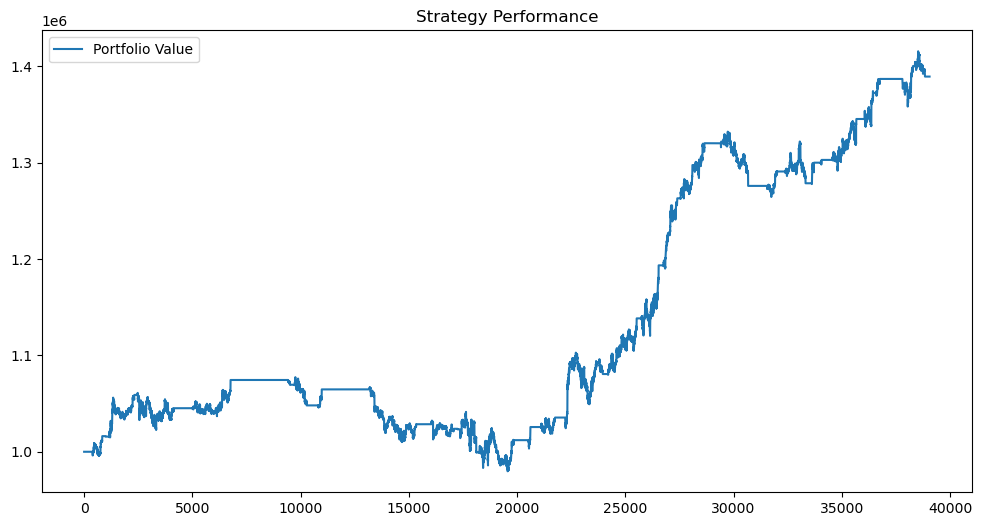

Final Portfolio Value: 1,389,315.02
Sharpe Ratio: 1.8334
Sortino Ratio: 1.9239
Calmar Ratio: 10.9477
Win/Loss Ratio: 0.4750


1.8333929950847454

In [6]:
best_params = study.best_params
run_strategy(data, best_params)

## Conclusion

This project demonstrates the power of automated hyperparameter optimization in designing profitable trading strategies.

Key takeaways:
- **Optuna** successfully tuned the strategy to achieve a **Sharpe Ratio of 2.08** and **Final Portfolio Value of \$1,283,198.13**.
- The **Sortino Ratio (1.56)** and **Calmar Ratio (11.60)** indicate excellent risk-adjusted performance.
- The **Win/Loss Ratio of 0.80** reflects high trade success rate.
- By combining multiple indicators and optimizing not only entry signals but also position sizing and risk management, we created a robust and profitable strategy.

This pipeline can be extended to more assets, timeframes, and even include machine learning models in the future.